In [30]:
import numpy as np
import datetime
from matplotlib import pyplot as plt
from functools import partial
from ionoptics import geometry as geo
from ionoptics import beamline as bl
from ionoptics import bmad

In [ ]:
## beamsize

# 1 sigma x = 6 mm
# 1 sigma y = 9 mm

## quadrupole position evaluation

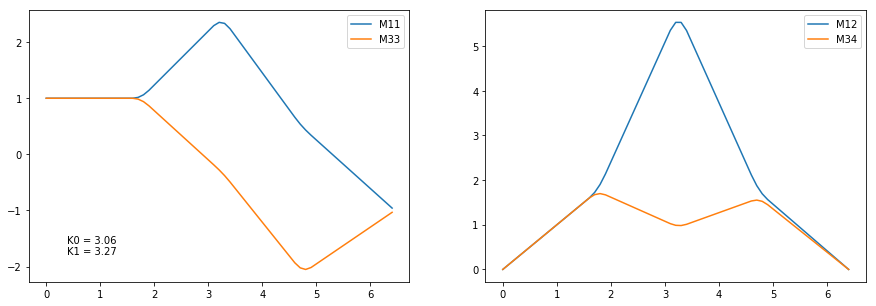

total length:  6.5


In [17]:
l = 1.6 # from object to 1st q
L = 0.3 # q thickness
d = 1.2 # dist. betw. q's

k0,k1 = bl.opt_trip(l,L,d,[2,3])

lengths = [l,L,d,L,d,L,l]
elements = [bl.drift,partial(bl.qdf, k=k0),bl.drift,partial(bl.qf, k=k1),bl.drift,partial(bl.qdf, k=k0),bl.drift]

axes = bl.plot_M_vs_s(elements,lengths,figsize = (15,5))

axes[0].text(0.1,0.1,'K0 = {:.2f}\nK1 = {:.2f}'.format(k0,k1),transform=axes[0].transAxes)

plt.show()
print('total length: ', round(2*l+2*d+3*L,2))

### bmad cross check

xmax @  start: 0.019822675559546376
xmax @  end: 0.022857132472779467
ymax @  start: 0.03226760626562391
ymax @  end: 0.03381164169076117


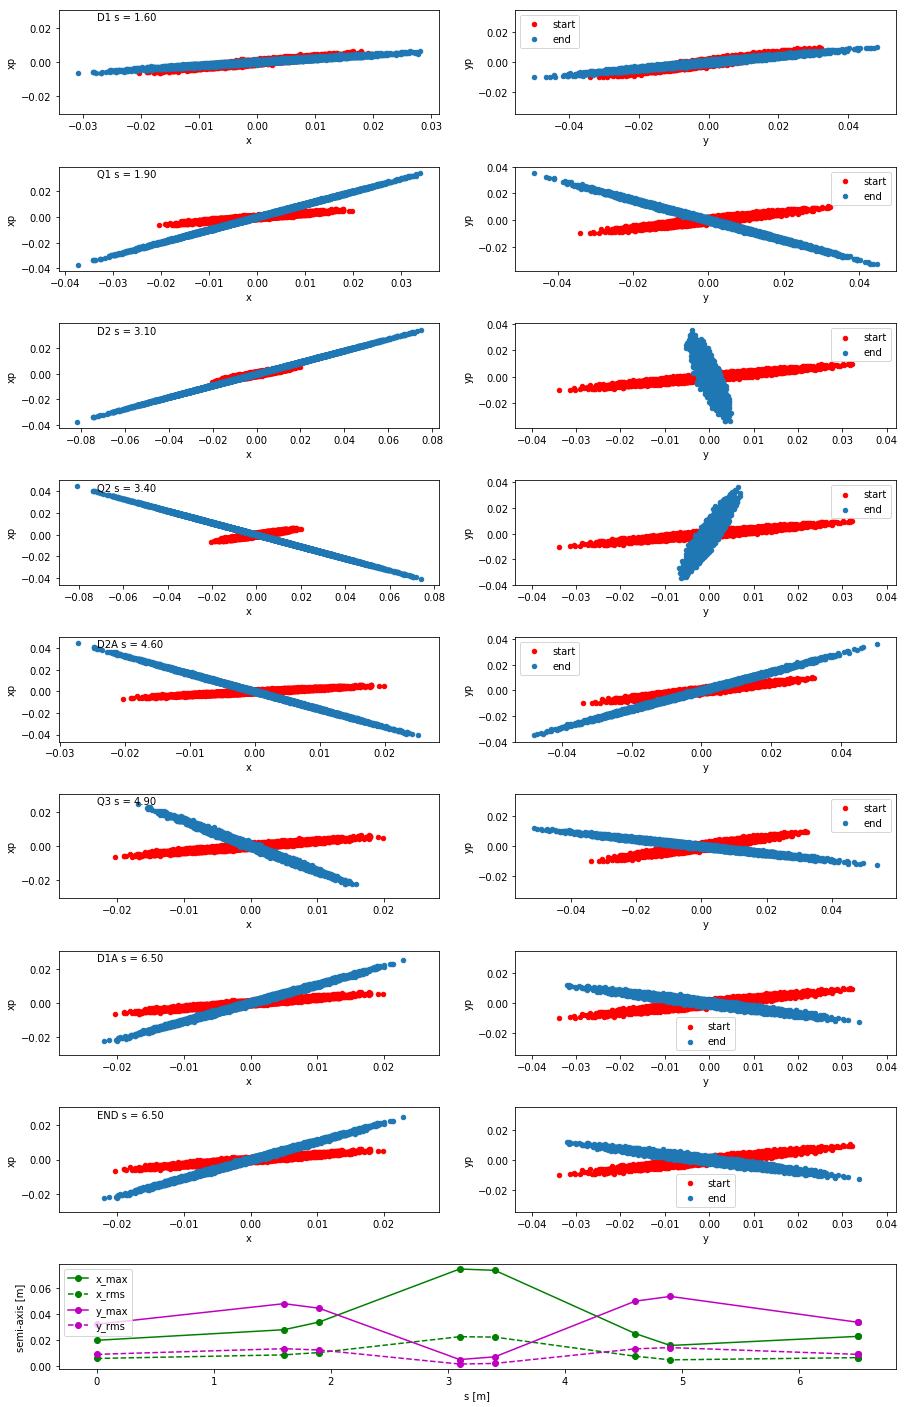

In [31]:
df = bmad.txt_to_df('../../Bmad/Playground/production/bin/','tracking_ele.txt')
bmad.plot_phase_space(df,figsize=(15,25))

#PATH_TO_DATA = '../../Multiplexer/Plots/'
#FILENAME = 'pure_tr-{date:%Y-%m-%d %H:%M:%S}'.format(date=datetime.datetime.now())
#plt.savefig(PATH_TO_DATA + FILENAME, format = 'png', dpi=900)
plt.show()

## kick-septum angle evaluation

In [18]:
## beam parameters
sigma_x = 6e-3
Thet_init = 0

## distances
l_object = 0.1 # previous object to kicker (minimum)
l_kick = 0.5
l_sept = 0.5

lkq = d-l_kick-l_object
l_max = d + L + lkq # d: from q to q

## vertical distances
x_init = 0

# at septum
septum = 5e-3
x_sept = 4*sigma_x+septum
# at max prop
x_at_max_prop = 0.5
x_add = x_at_max_prop-x_sept

## iteration

start_kick = 0.001 # smallest kick-angle
step_kick = 0.001 # step size kick-angle

list_perm = np.linspace(0,1,1001) # range of septum angles

In [29]:
l_max

2.1

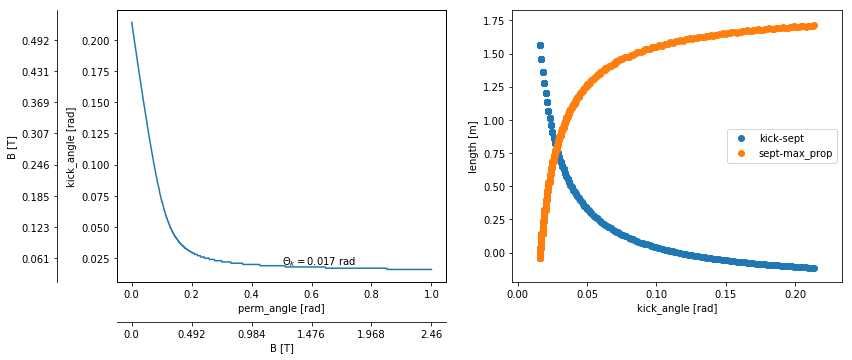

In [19]:
ax,data= geo.plot_comb_kick_sept(x_sept,
                                 x_add,
                                 x_init,
                                 Thet_init,
                                 l_kick,
                                 l_sept,
                                 'OFS',
                                 start_kick,
                                 step_kick,
                                 list_perm,
                                 l_max,
                                 brho=1.23,
                                 figsize = (13,5)
                                )

plt.show()

In [20]:
kick_d = data[0][0.4]

dks = [d[1] for d in data[1] if d[0] == kick_d]
dks_av = sum(dks)/len(dks)
# kicker-septum


dsf = [d[1] for d in data[2] if d[0] == kick_d]
dsf_av = sum(dsf)/len(dsf)
# septum - final

(kick_d,dks_av,dsf_av)

(0.02, 1.2000800037334902, 0.35921180493870897)

## reduced kicker strength by quadrupole

In [21]:
kick_d*lkq

0.012

In [24]:
geo.quad_defl(k0,0.3,18e-3,l_kick,lkq,dks_av-lkq-L)

0.029727366754486825